# Uber Fare Prediction with K-Nearest Neighbors Regression

This notebook shows how to predict Uber fares using a KNN regressor:
1. Load & clean data  
2. Feature engineering  
3. Train/test split  
4. Hyperparameter tuning  
5. Evaluation  
6. Visualizations


In [4]:
# 1) Imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


In [5]:
# Loading data

data_dir = os.path.dirname(r"C:\Users\jbats\Projects\cmor438\data\uber.csv")
print("Files in data folder:", os.listdir(data_dir))

data_path = os.path.join(data_dir, "uber.csv")
df = pd.read_csv(data_path)
print("Raw shape:", df.shape)

df.head()


Files in data folder: ['Cleaned_dataset.csv', 'MarketFarePredictionData.zip', 'uber.csv']
Raw shape: (200000, 9)


,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


In [6]:
###Feature Engineering

###1: Extract date-time features

df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
df['hour']    = df['pickup_datetime'].dt.hour
df['weekday'] = df['pickup_datetime'].dt.weekday
df['month']   = df['pickup_datetime'].dt.month

### 2. Haversine function to compute distance
def haversine(lat1, lon1, lat2, lon2):
    R = 6371.0  # Earth radius in km
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    return 2 * R * np.arcsin(np.sqrt(a))

df['distance_km'] = haversine(
    df.pickup_latitude, df.pickup_longitude,
    df.dropoff_latitude, df.dropoff_longitude
)
df[['pickup_latitude','dropoff_latitude','distance_km']].head()

## 3. Data Cleaning
# remove zero/negative trips
df = df[(df.distance_km > 0) & (df.fare_amount > 0)]
print("After basic clean:", df.shape)

# cap at 99th percentile
dist_cap = df.distance_km.quantile(0.99)
fare_cap = df.fare_amount.quantile(0.99)
df.distance_km = df.distance_km.clip(upper=dist_cap)
df.fare_amount = df.fare_amount.clip(upper=fare_cap)

## Additional Features & Target Transform
df['is_weekend']   = (df.weekday >= 5).astype(int)
df['morning_peak'] = df.hour.between(7,9).astype(int)
df['dist_x_pass']  = df.distance_km * df.passenger_count

# log-transform fare
df['fare_log'] = np.log1p(df.fare_amount)

After basic clean: (194347, 13)


In [7]:
## Train/Test Split 

features = [
    'passenger_count','distance_km','hour','weekday','month',
    'is_weekend','morning_peak','dist_x_pass'
]
X = df[features]
y_log  = df['fare_log']
y_fare = df['fare_amount']

X_train, X_test, ylog_train, ylog_test, yfare_train, yfare_test = train_test_split(
    X, y_log, y_fare, test_size=0.2, random_state=42
)
print("Train/Test shapes:", X_train.shape, X_test.shape)


Train/Test shapes: (155477, 8) (38870, 8)


In [8]:
## Pipeline and Hyperparameter Tuning

preprocessor = ColumnTransformer([('num', StandardScaler(), features)])
pipe = Pipeline([('pre', preprocessor), ('knn', KNeighborsRegressor())])

param_grid = {
    "knn__n_neighbors": [5,10,15,20,25],
    "knn__weights":     ["uniform","distance"],
    "knn__p":           [1,2]
}
search = GridSearchCV(pipe, param_grid, cv=3, n_jobs=-1,
                      scoring="neg_mean_absolute_error")
search.fit(X_train, ylog_train)

print("Best params:", search.best_params_)
print("Best CV MAE (log):", -search.best_score_)




Best params: {'knn__n_neighbors': 25, 'knn__p': 1, 'knn__weights': 'uniform'}
Best CV MAE (log): 0.18141214654902113


In [9]:
## Evaluate on Test Set

best = search.best_estimator_
ylog_pred = best.predict(X_test)
y_pred    = np.expm1(ylog_pred)

mse = mean_squared_error(yfare_test, y_pred)
mae = mean_absolute_error(yfare_test, y_pred)
r2  = r2_score(yfare_test, y_pred)
within_4 = np.mean(np.abs(y_pred - yfare_test) <= 4)

print(f"Test MSE: {mse:.2f}")
print(f"Test MAE: {mae:.2f}")
print(f"Test R² : {r2:.3f}")
print(f"±$4 accuracy: {within_4:.1%}")


Test MSE: 18.87
Test MAE: 2.31
Test R² : 0.765
±$4 accuracy: 86.7%


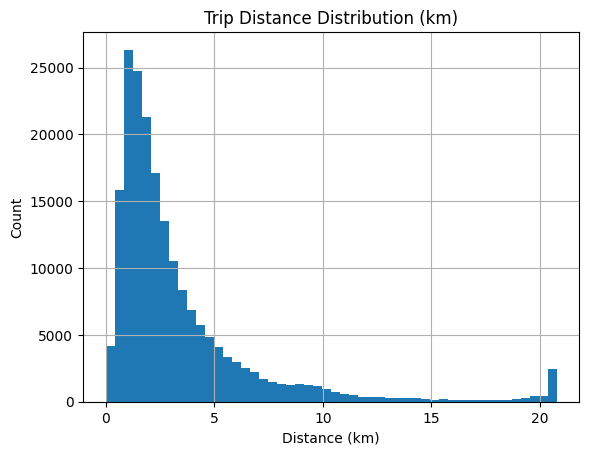

In [10]:
## Visualizations

# Distribution of trip distances
plt.figure()
df.distance_km.hist(bins=50)
plt.title('Trip Distance Distribution (km)')
plt.xlabel('Distance (km)')
plt.ylabel('Count')
plt.show()




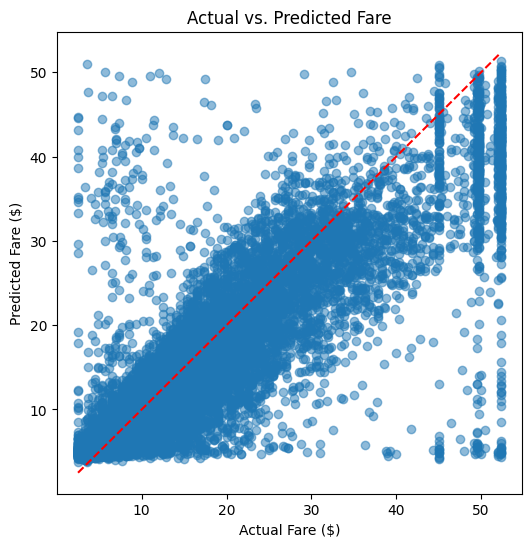

In [11]:
##Results 

# Actual vs Predicted fares
plt.figure(figsize=(6,6))
plt.scatter(yfare_test, y_pred, alpha=0.5)
plt.plot([yfare_test.min(), yfare_test.max()],
         [yfare_test.min(), yfare_test.max()], 'r--')
plt.title('Actual vs. Predicted Fare')
plt.xlabel('Actual Fare ($)')
plt.ylabel('Predicted Fare ($)')
plt.show()
